In [1]:
import json
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt

In [2]:
root_directory_for_pbns = (
    "/scratch/zhivar/robust-prototype-learning/PBN_transformer/summaries"
)

root_directory_for_normal_models = (
    "/scratch/zhivar/robust-prototype-learning/datasets/summaries"
)

In [3]:
def get_attack_type(file_path):
    for attack_type in ["textfooler", "textbugger", "deepwordbug", "pwws", "bae"]:
        if attack_type.lower() in file_path.lower():
            return attack_type
    raise ValueError(f"Unknown attack type for file {file_path}")


def get_classifier_model(file_path):
    for classifier in [
        "electra-base-discriminator",
        "bart-base-mnli",
        "bert-medium",
        "electra",
        "bert",
        "bart",
    ]:
        if classifier.lower() in file_path.lower():
            return classifier.split("-")[0]
    return "bart"


def get_dataset(file_path):
    for dataset in ["imdb", "sst2", "ag_news", "dbpedia"]:
        if dataset.lower() in file_path.lower():
            return dataset
    raise ValueError(f"Unknown dataset for file {file_path}")


def get_the_hyperparameters(file_path):
    dictionary_to_correct_values = {
        0: 0.0,
        9: 0.9,
        100: 10.0,
        2: 2,
        4: 4,
        8: 8,
        16: 16,
        64: 64,
    }
    pattern_to_look_for = re.compile(r".*_(\d+)\_(\d+)\_(\d+)\_(\d+).*")
    second_pattern_to_look_for = re.compile(r".*_(\d+)_(\d+)_(\d+).*")

    matched_integers = re.match(pattern_to_look_for, file_path)
    if matched_integers:
        return [dictionary_to_correct_values[int(x)] for x in matched_integers.groups()]
    else:
        matched_integers = re.match(second_pattern_to_look_for, file_path)
        if matched_integers:
            return [
                dictionary_to_correct_values[int(x)]
                for x in (*matched_integers.groups(), 16)
            ]
    raise ValueError(f"Could not find hyperparameters for file {file_path}")

In [4]:
random_file_name_1 = "summary_ag_news_textbugger_BERT_ag_news_model_09_09_09_4.json"
random_file_name_2 = "summary_ag_news_textbugger_ag_news_model_09_09_09_ELECTRA.json"
random_file_name_3 = "summary_ag_news_textfooler_BERT_ag_news_model_09_100_09_16.json"
random_file_name_4 = "summary_imdb_deepwordbug_ELECTRA_imdb_model_100_09_09_16.json"

for file_name in [
    random_file_name_1,
    random_file_name_2,
    random_file_name_3,
    random_file_name_4,
]:
    print(get_the_hyperparameters(file_name))

[0.9, 0.9, 0.9, 4]
[0.9, 0.9, 0.9, 16]
[0.9, 10.0, 0.9, 16]
[10.0, 0.9, 0.9, 16]


In [5]:
def process_file_pbn(log_file, root_directory):
    with open(os.path.join(root_directory, log_file), "r") as f:
        data = json.load(f)
        f.close()
    if "result" in data.keys():
        data_object = {
            "file_path": log_file,
            "attack_type": get_attack_type(log_file),
            "classifier_model": get_classifier_model(log_file),
            "dataset": get_dataset(log_file),
            "hyperparameters": get_the_hyperparameters(log_file),
            "comment": data["result"],
        }
    else:
        data = data["Attack Results"]
        data_object = {
            "file_path": log_file,
            "attack_type": get_attack_type(log_file),
            "classifier_model": get_classifier_model(log_file),
            "dataset": get_dataset(log_file),
            "hyperparameters": get_the_hyperparameters(log_file),
            "Number of successful attacks:": data["Number of successful attacks:"],
            "Number of failed attacks:": data["Number of failed attacks:"],
            "Number of skipped attacks:": data["Number of skipped attacks:"],
            "Original accuracy:": data["Original accuracy:"],
            "Accuracy under attack:": data["Accuracy under attack:"],
            "Attack success rate:": data["Attack success rate:"],
            "Average perturbed word %:": data["Average perturbed word %:"],
            "Average num. words per input:": data["Average num. words per input:"],
            "Avg num queries:": data["Avg num queries:"],
            "comment": "successful",
        }
    return data_object

In [6]:
all_log_files = [
    file for file in os.listdir(root_directory_for_pbns) if file.startswith("summary_")
]

all_data_objects = []

for log_file in all_log_files:
    try:
        data_object = process_file_pbn(log_file, root_directory_for_pbns)
        all_data_objects.append(data_object)
    except Exception as e:
        print(e)
        print(f"Failed to process file {log_file}")
        continue

results_df_pbn = pd.DataFrame(all_data_objects)
results_df_pbn

,file_path,attack_type,classifier_model,dataset,hyperparameters,Number of successful attacks:,Number of failed attacks:,Number of skipped attacks:,Original accuracy:,Accuracy under attack:,Attack success rate:,Average perturbed word %:,Average num. words per input:,Avg num queries:,comment
0,summary_imdb_textfooler_imdb_model_09_09_09.json,textfooler,bart,imdb,"[0.9, 0.9, 0.9, 16]",800.0,106.0,71.0,92.73,10.85,88.30,12.13,230.47,1035.63,successful
1,summary_dbpedia_textfooler_dbpedia_model_09_09...,textfooler,bart,dbpedia,"[0.9, 0.9, 0.9, 16]",800.0,700.0,9.0,99.40,46.39,53.33,25.99,103.83,918.13,successful
2,summary_imdb_textbugger_imdb_model_09_09_09.json,textbugger,bart,imdb,"[0.9, 0.9, 0.9, 16]",800.0,1020.0,128.0,93.43,52.36,43.96,28.40,227.61,662.42,successful
3,summary_ag_news_textfooler_ag_news_model_09_09...,textfooler,bart,ag_news,"[0.9, 0.9, 0.9, 16]",800.0,487.0,119.0,91.54,34.64,62.16,24.11,37.93,385.60,successful
4,summary_ag_news_textbugger_ag_news_model_09_09...,textbugger,bart,ag_news,"[0.9, 0.9, 0.9, 16]",800.0,2456.0,274.0,92.24,69.58,24.57,30.61,38.32,184.35,successful
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,summary_imdb_textfooler_BART_imdb_model_100_09...,textfooler,bart,imdb,"[10.0, 0.9, 0.9, 16]",800.0,72.0,80.0,91.60,7.56,91.74,10.43,229.52,876.68,successful
441,summary_imdb_textbugger_BART_imdb_model_00_09_...,textbugger,bart,imdb,"[0.0, 0.9, 0.9, 16]",800.0,1139.0,152.0,92.73,54.47,41.26,28.18,226.91,678.04,successful
442,summary_imdb_textbugger_BART_imdb_model_100_09...,textbugger,bart,imdb,"[10.0, 0.9, 0.9, 16]",800.0,853.0,136.0,92.40,47.68,48.40,29.35,227.45,620.85,successful
443,summary_imdb_deepwordbug_BART_imdb_model_00_09...,deepwordbug,bart,imdb,"[0.0, 0.9, 0.9, 16]",800.0,1148.0,152.0,92.76,54.67,41.07,5.97,226.85,369.47,successful


In [7]:
results_df_pbn[
    (results_df_pbn["hyperparameters"].apply(lambda x: x[1] == 10.0))
    & (results_df_pbn["dataset"] == "imdb")
]

,file_path,attack_type,classifier_model,dataset,hyperparameters,Number of successful attacks:,Number of failed attacks:,Number of skipped attacks:,Original accuracy:,Accuracy under attack:,Attack success rate:,Average perturbed word %:,Average num. words per input:,Avg num queries:,comment
278,summary_imdb_textfooler_BERT_imdb_model_09_100...,textfooler,bert,imdb,"[0.9, 10.0, 0.9, 16]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This model is not accurate enough in the first...
282,summary_imdb_textbugger_BERT_imdb_model_09_100...,textbugger,bert,imdb,"[0.9, 10.0, 0.9, 16]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This model is not accurate enough in the first...
286,summary_imdb_deepwordbug_BERT_imdb_model_09_10...,deepwordbug,bert,imdb,"[0.9, 10.0, 0.9, 16]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This model is not accurate enough in the first...
290,summary_imdb_pwws_BERT_imdb_model_09_100_09_16...,pwws,bert,imdb,"[0.9, 10.0, 0.9, 16]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This model is not accurate enough in the first...
294,summary_imdb_bae_BERT_imdb_model_09_100_09_16....,bae,bert,imdb,"[0.9, 10.0, 0.9, 16]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This model is not accurate enough in the first...
323,summary_imdb_textfooler_ELECTRA_imdb_model_09_...,textfooler,electra,imdb,"[0.9, 10.0, 0.9, 16]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This model is not accurate enough in the first...
327,summary_imdb_textbugger_ELECTRA_imdb_model_09_...,textbugger,electra,imdb,"[0.9, 10.0, 0.9, 16]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This model is not accurate enough in the first...
331,summary_imdb_deepwordbug_ELECTRA_imdb_model_09...,deepwordbug,electra,imdb,"[0.9, 10.0, 0.9, 16]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This model is not accurate enough in the first...
335,summary_imdb_pwws_ELECTRA_imdb_model_09_100_09...,pwws,electra,imdb,"[0.9, 10.0, 0.9, 16]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This model is not accurate enough in the first...
339,summary_imdb_bae_ELECTRA_imdb_model_09_100_09_...,bae,electra,imdb,"[0.9, 10.0, 0.9, 16]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This model is not accurate enough in the first...


In [8]:
def is_attacked_normal_model(file_path):
    for classifier in [
        "electra-base-discriminator",
        "bart-base-mnli",
        "bert-medium",
    ]:
        if classifier.lower() in file_path.lower():
            return True
    return False

In [9]:
def process_file_non_pbn(log_file, root_directory):
    with open(os.path.join(root_directory, log_file), "r") as f:
        data = json.load(f)
        f.close()

    data = data["Attack Results"]
    data_object = {
        "file_path": log_file,
        "attack_type": get_attack_type(log_file),
        "classifier_model": get_classifier_model(log_file),
        "dataset": get_dataset(log_file),
        "hyperparameters": None,
        "Number of successful attacks:": data["Number of successful attacks:"],
        "Number of failed attacks:": data["Number of failed attacks:"],
        "Number of skipped attacks:": data["Number of skipped attacks:"],
        "Original accuracy:": data["Original accuracy:"],
        "Accuracy under attack:": data["Accuracy under attack:"],
        "Attack success rate:": data["Attack success rate:"],
        "Average perturbed word %:": data["Average perturbed word %:"],
        "Average num. words per input:": data["Average num. words per input:"],
        "Avg num queries:": data["Avg num queries:"],
        "comment": "successful",
    }
    return data_object

In [10]:
all_log_files = [
    file
    for file in os.listdir(root_directory_for_normal_models)
    if file.startswith("summary_")
]

all_data_objects = []

for log_file in all_log_files:
    if not is_attacked_normal_model(log_file):
        continue
    try:
        data_object = process_file_non_pbn(log_file, root_directory_for_normal_models)
        all_data_objects.append(data_object)
    except Exception as e:
        print(e)
        continue

results_df_non_pbns = pd.DataFrame(all_data_objects)
results_df_non_pbns.head(3)

,file_path,attack_type,classifier_model,dataset,hyperparameters,Number of successful attacks:,Number of failed attacks:,Number of skipped attacks:,Original accuracy:,Accuracy under attack:,Attack success rate:,Average perturbed word %:,Average num. words per input:,Avg num queries:,comment
0,summary_imdb_textfooler__normal_models_models_...,textfooler,bart,imdb,None,800,0,73,91.64,0.00,100.00,5.92,231.20,442.62,successful
1,summary_imdb_textbugger__normal_models_models_...,textbugger,bart,imdb,None,800,219,85,92.30,19.84,78.51,33.32,230.43,428.52,successful
2,summary_ag_news_textfooler__normal_models_mode...,textfooler,bart,ag_news,None,800,246,93,91.83,21.60,76.48,25.00,37.90,333.32,successful


In [11]:
results_df_pbn = results_df_pbn[results_df_pbn["comment"] == "successful"]
results_df_pbn["comment"] = "PBN"
results_df_non_pbns["comment"] = "non_PBN"

/tmp/ipykernel_131513/3444515158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_pbn["comment"] = "PBN"


In [12]:
results_df_merged = pd.concat([results_df_pbn, results_df_non_pbns])
results_df_merged.head(3)

,file_path,attack_type,classifier_model,dataset,hyperparameters,Number of successful attacks:,Number of failed attacks:,Number of skipped attacks:,Original accuracy:,Accuracy under attack:,Attack success rate:,Average perturbed word %:,Average num. words per input:,Avg num queries:,comment
0,summary_imdb_textfooler_imdb_model_09_09_09.json,textfooler,bart,imdb,"[0.9, 0.9, 0.9, 16]",800.0,106.0,71.0,92.73,10.85,88.30,12.13,230.47,1035.63,PBN
1,summary_dbpedia_textfooler_dbpedia_model_09_09...,textfooler,bart,dbpedia,"[0.9, 0.9, 0.9, 16]",800.0,700.0,9.0,99.40,46.39,53.33,25.99,103.83,918.13,PBN
2,summary_imdb_textbugger_imdb_model_09_09_09.json,textbugger,bart,imdb,"[0.9, 0.9, 0.9, 16]",800.0,1020.0,128.0,93.43,52.36,43.96,28.40,227.61,662.42,PBN


In [13]:
attack_success_rate_summary_results = (
    results_df_merged.groupby(["dataset", "classifier_model", "attack_type"])
    .apply(
        lambda x: (
            x[x["comment"] == "PBN"]["Attack success rate:"].mean(),
            x[x["comment"] == "non_PBN"]["Attack success rate:"].mean(),
        )
    )
    .reset_index()
    .rename(columns={0: "Attack success rate"})
)
print(
    "The rate at which the PBN model attack success rate is lower than non PBN model attack success rate (on average)",
    attack_success_rate_summary_results[
        attack_success_rate_summary_results["Attack success rate"].apply(
            lambda x: x[0] < x[1]
        )
    ].shape[0]
    / attack_success_rate_summary_results.shape[0],
)
attack_success_rate_summary_results.head(3)

The rate at which the PBN model attack success rate is lower than non PBN model attack success rate (on average) 0.8888888888888888


,dataset,classifier_model,attack_type,Attack success rate
0,ag_news,bart,bae,"(14.993333333333332, 14.82)"
1,ag_news,bart,deepwordbug,"(41.22222222222222, 53.16)"
2,ag_news,bart,pwws,"(51.760000000000005, 53.62)"


In [14]:
attack_success_rate_summary_results = (
    results_df_merged.groupby(["dataset", "classifier_model", "attack_type"])
    .apply(
        lambda x: (
            x[x["comment"] == "PBN"]["Attack success rate:"].min(),
            x[x["comment"] == "non_PBN"]["Attack success rate:"].min(),
        )
    )
    .reset_index()
    .rename(columns={0: "Attack success rate"})
)
print(
    "The rate at which the PBN model attack success rate is lower than non PBN model attack success rate (taking the best hyperparameters)",
    attack_success_rate_summary_results[
        attack_success_rate_summary_results["Attack success rate"].apply(
            lambda x: x[0] < x[1]
        )
    ].shape[0]
    / attack_success_rate_summary_results.shape[0],
)
attack_success_rate_summary_results.head(3)

The rate at which the PBN model attack success rate is lower than non PBN model attack success rate (taking the best hyperparameters) 0.9333333333333333


,dataset,classifier_model,attack_type,Attack success rate
0,ag_news,bart,bae,"(11.09, 14.82)"
1,ag_news,bart,deepwordbug,"(32.3, 53.16)"
2,ag_news,bart,pwws,"(41.93, 53.62)"


In [15]:
results_df_pbn["p1_lamb"] = results_df_pbn["hyperparameters"].apply(lambda x: x[0])
results_df_pbn["p2_lamb"] = results_df_pbn["hyperparameters"].apply(lambda x: x[1])
results_df_pbn["p3_lamb"] = results_df_pbn["hyperparameters"].apply(lambda x: x[2])
results_df_pbn["num_proto"] = results_df_pbn["hyperparameters"].apply(lambda x: x[3])

/tmp/ipykernel_131513/2201319661.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_pbn["p1_lamb"] = results_df_pbn["hyperparameters"].apply(lambda x: x[0])
/tmp/ipykernel_131513/2201319661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_pbn["p2_lamb"] = results_df_pbn["hyperparameters"].apply(lambda x: x[1])
/tmp/ipykernel_131513/2201319661.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

82.42933333333333


59.22533333333334
37.150666666666666


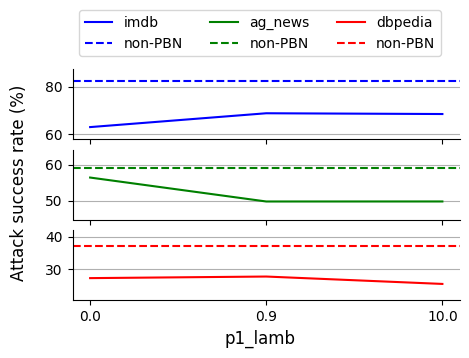

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(5, 3), sharex=True)
dataset_to_colors = {
    "imdb": "blue",
    "ag_news": "green",
    "dbpedia": "red",
}
for ax, dataset in zip(axs, ["imdb", "ag_news", "dbpedia"]):
    sub_df = results_df_pbn[results_df_pbn["dataset"] == dataset]
    results = sub_df.groupby("p1_lamb")["Attack success rate:"].mean()
    non_pbn_baseline = results_df_non_pbns[(results_df_non_pbns["dataset"] == dataset)][
        "Attack success rate:"
    ].mean()
    print(non_pbn_baseline)
    x = results.index
    y = results.values
    x_to_y = dict(zip(x, y))
    correct_indices = [0.0, 0.9, 10.0]

    ax.plot(
        range(len(correct_indices)),
        [x_to_y.get(i, non_pbn_baseline + 5) for i in correct_indices],
        label=dataset,
        color=dataset_to_colors[dataset],
    )

    ax.axhline(
        y=non_pbn_baseline,
        color=dataset_to_colors[dataset],
        linestyle="--",
        label="non-PBN",
    )
    ax.set_ylim(min(min(y), non_pbn_baseline) - 5, max(max(y), non_pbn_baseline) + 5)
    ax.grid(axis="y")
    ax.set_xticks(range(len(correct_indices)))
    ax.set_xticklabels(correct_indices)

# remove the spines between the plots
# axs[0].spines["bottom"].set_visible(False)
# axs[1].spines["top"].set_visible(False)
# axs[1].spines["bottom"].set_visible(False)
# axs[2].spines["top"].set_visible(False)
# remove the xaxis for all but the bottom plot
# axs[0].xaxis.set_visible(False)
# axs[1].xaxis.set_visible(False)
# remove all the upper and right axes
for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# plt.xlabel("p1_lamb")
# plt.ylabel("Attack success rate (%)")
# d = 1.0  # proportion of vertical to horizontal extent of the slanted line
# kwargs = dict(
#     marker=[(-1, -d), (1, d)],
#     markersize=12,
#     linestyle="none",
#     color="k",
#     mec="k",
#     mew=1,
#     clip_on=False,
# )

# get all the legends and aggregate them
handles = []
labels = []
for ax in axs:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.1))


fig.supxlabel("p1_lamb", y=-0.05, ha="center")
fig.supylabel("Attack success rate (%)", x=0.0, ha="left")

# axs[0].plot([0, 1], [0, 0], transform=axs[0].transAxes, **kwargs)
# axs[1].plot([0, 1], [1, 1], transform=axs[1].transAxes, **kwargs)
# axs[1].plot([0, 1], [0, 0], transform=axs[1].transAxes, **kwargs)
# axs[2].plot([0, 1], [1, 1], transform=axs[2].transAxes, **kwargs)

# reduce the space between the plots
fig.subplots_adjust(hspace=0.15)
plt.show()

82.42933333333333
59.22533333333334
37.150666666666666


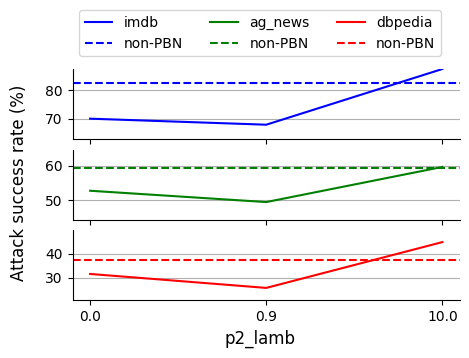

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(5, 3), sharex=True)
dataset_to_colors = {
    "imdb": "blue",
    "ag_news": "green",
    "dbpedia": "red",
}
for ax, dataset in zip(axs, ["imdb", "ag_news", "dbpedia"]):
    sub_df = results_df_pbn[results_df_pbn["dataset"] == dataset]
    results = sub_df.groupby("p2_lamb")["Attack success rate:"].mean()
    non_pbn_baseline = results_df_non_pbns[(results_df_non_pbns["dataset"] == dataset)][
        "Attack success rate:"
    ].mean()
    print(non_pbn_baseline)
    x = results.index
    y = results.values
    x_to_y = dict(zip(x, y))
    correct_indices = [0.0, 0.9, 10.0]

    ax.plot(
        range(len(correct_indices)),
        [x_to_y.get(i, non_pbn_baseline + 5) for i in correct_indices],
        label=dataset,
        color=dataset_to_colors[dataset],
    )
    ax.axhline(
        y=non_pbn_baseline,
        color=dataset_to_colors[dataset],
        linestyle="--",
        label="non-PBN",
    )
    ax.set_ylim(min(min(y), non_pbn_baseline) - 5, max(max(y), non_pbn_baseline) + 5)
    ax.grid(axis="y")
    ax.set_xticks(range(len(correct_indices)))
    ax.set_xticklabels(correct_indices)

# remove the spines between the plots
# axs[0].spines["bottom"].set_visible(False)
# axs[1].spines["top"].set_visible(False)
# axs[1].spines["bottom"].set_visible(False)
# axs[2].spines["top"].set_visible(False)
# remove the xaxis for all but the bottom plot
# axs[0].xaxis.set_visible(False)
# axs[1].xaxis.set_visible(False)
# remove all the upper and right axes
for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# plt.xlabel("p2_lamb")
# plt.ylabel("Attack success rate (%)")
# d = 1.0  # proportion of vertical to horizontal extent of the slanted line
# kwargs = dict(
#     marker=[(-1, -d), (1, d)],
#     markersize=12,
#     linestyle="none",
#     color="k",
#     mec="k",
#     mew=1,
#     clip_on=False,
# )

# get all the legends and aggregate them
handles = []
labels = []
for ax in axs:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.1))


fig.supxlabel("p2_lamb", y=-0.05, ha="center")
fig.supylabel("Attack success rate (%)", x=0.0, ha="left")

# axs[0].plot([0, 1], [0, 0], transform=axs[0].transAxes, **kwargs)
# axs[1].plot([0, 1], [1, 1], transform=axs[1].transAxes, **kwargs)
# axs[1].plot([0, 1], [0, 0], transform=axs[1].transAxes, **kwargs)
# axs[2].plot([0, 1], [1, 1], transform=axs[2].transAxes, **kwargs)

# reduce the space between the plots
fig.subplots_adjust(hspace=0.15)
plt.show()

82.42933333333333
59.22533333333334
37.150666666666666


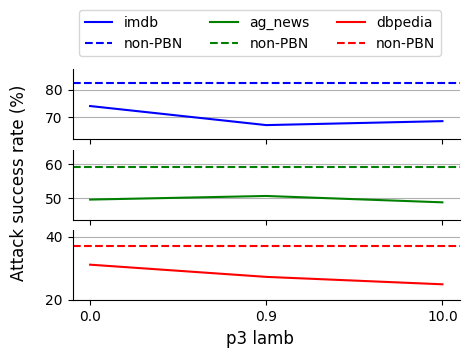

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(5, 3), sharex=True)
dataset_to_colors = {
    "imdb": "blue",
    "ag_news": "green",
    "dbpedia": "red",
}
for ax, dataset in zip(axs, ["imdb", "ag_news", "dbpedia"]):
    sub_df = results_df_pbn[results_df_pbn["dataset"] == dataset]
    results = sub_df.groupby("p3_lamb")["Attack success rate:"].mean()
    non_pbn_baseline = results_df_non_pbns[(results_df_non_pbns["dataset"] == dataset)][
        "Attack success rate:"
    ].mean()
    print(non_pbn_baseline)
    x = results.index
    y = results.values
    x_to_y = dict(zip(x, y))
    correct_indices = [0.0, 0.9, 10.0]

    ax.plot(
        range(len(correct_indices)),
        [x_to_y.get(i, non_pbn_baseline + 5) for i in correct_indices],
        label=dataset,
        color=dataset_to_colors[dataset],
    )
    ax.axhline(
        y=non_pbn_baseline,
        color=dataset_to_colors[dataset],
        linestyle="--",
        label="non-PBN",
    )
    ax.set_ylim(min(min(y), non_pbn_baseline) - 5, max(max(y), non_pbn_baseline) + 5)
    ax.grid(axis="y")
    ax.set_xticks(range(len(correct_indices)))
    ax.set_xticklabels(correct_indices)

# remove the spines between the plots
# axs[0].spines["bottom"].set_visible(False)
# axs[1].spines["top"].set_visible(False)
# axs[1].spines["bottom"].set_visible(False)
# axs[2].spines["top"].set_visible(False)
# remove the xaxis for all but the bottom plot
# axs[0].xaxis.set_visible(False)
# axs[1].xaxis.set_visible(False)
# remove all the upper and right axes
for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# plt.xlabel("p3_lamb")
# plt.ylabel("Attack success rate (%)")
# d = 1.0  # proportion of vertical to horizontal extent of the slanted line
# kwargs = dict(
#     marker=[(-1, -d), (1, d)],
#     markersize=12,
#     linestyle="none",
#     color="k",
#     mec="k",
#     mew=1,
#     clip_on=False,
# )

# get all the legends and aggregate them
handles = []
labels = []
for ax in axs:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.1))


fig.supxlabel("p3 lamb", y=-0.05, ha="center")
fig.supylabel("Attack success rate (%)", x=0.0, ha="left")

# axs[0].plot([0, 1], [0, 0], transform=axs[0].transAxes, **kwargs)
# axs[1].plot([0, 1], [1, 1], transform=axs[1].transAxes, **kwargs)
# axs[1].plot([0, 1], [0, 0], transform=axs[1].transAxes, **kwargs)
# axs[2].plot([0, 1], [1, 1], transform=axs[2].transAxes, **kwargs)

# reduce the space between the plots
fig.subplots_adjust(hspace=0.15)
plt.show()

82.42933333333333
{4: 58.64214285714286, 8: 68.94428571428571, 16: 68.63244680851064, 64: 76.333}
59.22533333333334
{2: 48.233, 4: 48.126, 8: 42.842, 16: 52.60171428571429, 64: 46.43266666666667}
37.150666666666666
{4: 21.719, 8: 20.86, 16: 29.10676056338028, 64: 27.165999999999997}


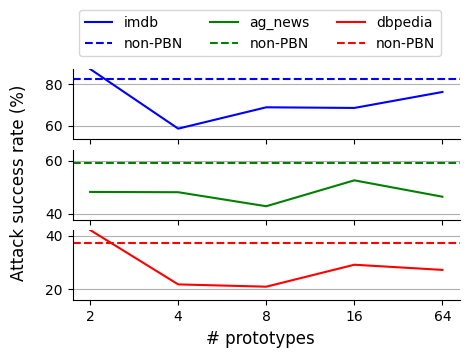

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(5, 3), sharex=True)
dataset_to_colors = {
    "imdb": "blue",
    "ag_news": "green",
    "dbpedia": "red",
}
for ax, dataset in zip(axs, ["imdb", "ag_news", "dbpedia"]):
    sub_df = results_df_pbn[results_df_pbn["dataset"] == dataset]
    results = sub_df.groupby("num_proto")["Attack success rate:"].mean()
    non_pbn_baseline = results_df_non_pbns[(results_df_non_pbns["dataset"] == dataset)][
        "Attack success rate:"
    ].mean()
    print(non_pbn_baseline)
    x = results.index
    y = results.values
    x_to_y = dict(zip(x, y))
    correct_indices = [2, 4, 8, 16, 64]
    print(x_to_y)

    ax.plot(
        range(len(correct_indices)),
        [x_to_y.get(i, non_pbn_baseline + 5) for i in correct_indices],
        label=dataset,
        color=dataset_to_colors[dataset],
    )
    ax.axhline(
        y=non_pbn_baseline,
        color=dataset_to_colors[dataset],
        linestyle="--",
        label="non-PBN",
    )
    ax.set_ylim(min(min(y), non_pbn_baseline) - 5, max(max(y), non_pbn_baseline) + 5)
    ax.grid(axis="y")
    ax.set_xticks(range(len(correct_indices)))
    ax.set_xticklabels(correct_indices)

# remove the spines between the plots
# axs[0].spines["bottom"].set_visible(False)
# axs[1].spines["top"].set_visible(False)
# axs[1].spines["bottom"].set_visible(False)
# axs[2].spines["top"].set_visible(False)
# remove the xaxis for all but the bottom plot
# axs[0].xaxis.set_visible(False)
# axs[1].xaxis.set_visible(False)
# remove all the upper and right axes
for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# plt.xlabel("num_proto")
# plt.ylabel("Attack success rate (%)")
# d = 1.0  # proportion of vertical to horizontal extent of the slanted line
# kwargs = dict(
#     marker=[(-1, -d), (1, d)],
#     markersize=12,
#     linestyle="none",
#     color="k",
#     mec="k",
#     mew=1,
#     clip_on=False,
# )

# get all the legends and aggregate them
handles = []
labels = []
for ax in axs:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.1))


fig.supxlabel("# prototypes", y=-0.05, ha="center")
fig.supylabel("Attack success rate (%)", x=0.0, ha="left")

# axs[0].plot([0, 1], [0, 0], transform=axs[0].transAxes, **kwargs)
# axs[1].plot([0, 1], [1, 1], transform=axs[1].transAxes, **kwargs)
# axs[1].plot([0, 1], [0, 0], transform=axs[1].transAxes, **kwargs)
# axs[2].plot([0, 1], [1, 1], transform=axs[2].transAxes, **kwargs)

# reduce the space between the plots
fig.subplots_adjust(hspace=0.15)
plt.show()

In [20]:
average_perturbed_word_summary_results = (
    results_df_merged.groupby(["dataset", "classifier_model", "attack_type"])
    .apply(
        lambda x: (
            x[x["comment"] == "PBN"]["Average perturbed word %:"].mean(),
            x[x["comment"] == "non_PBN"]["Average perturbed word %:"].mean(),
        )
    )
    .reset_index()
    .rename(columns={0: "Average perturbed word %"})
)
print(
    "The rate at which the the the \% average number of perturbations is higher in PBN model than non PBN model (on average)",
    average_perturbed_word_summary_results[
        average_perturbed_word_summary_results["Average perturbed word %"].apply(
            lambda x: x[0] > x[1]
        )
    ].shape[0]
    / average_perturbed_word_summary_results.shape[0],
)
average_perturbed_word_summary_results.head(3)

The rate at which the the the \% average number of perturbations is higher in PBN model than non PBN model (on average) 0.28888888888888886


,dataset,classifier_model,attack_type,Average perturbed word %
0,ag_news,bart,bae,"(8.338888888888889, 8.74)"
1,ag_news,bart,deepwordbug,"(19.40777777777778, 26.88)"
2,ag_news,bart,pwws,"(20.456666666666667, 20.82)"


In [21]:
average_perturbed_word_summary_results = (
    results_df_merged.groupby(["dataset", "classifier_model", "attack_type"])
    .apply(
        lambda x: (
            x[x["comment"] == "PBN"]["Average perturbed word %:"].max(),
            x[x["comment"] == "non_PBN"]["Average perturbed word %:"].max(),
        )
    )
    .reset_index()
    .rename(columns={0: "Average perturbed word %"})
)
print(
    "The rate at which the the the \% average number of perturbations is higher in PBN model than non PBN model, taking the best hyperparameters",
    average_perturbed_word_summary_results[
        average_perturbed_word_summary_results["Average perturbed word %"].apply(
            lambda x: x[0] > x[1]
        )
    ].shape[0]
    / average_perturbed_word_summary_results.shape[0],
)
average_perturbed_word_summary_results.head(3)

The rate at which the the the \% average number of perturbations is higher in PBN model than non PBN model, taking the best hyperparameters 0.6888888888888889


,dataset,classifier_model,attack_type,Average perturbed word %
0,ag_news,bart,bae,"(9.02, 8.74)"
1,ag_news,bart,deepwordbug,"(24.82, 26.88)"
2,ag_news,bart,pwws,"(22.16, 20.82)"
